# Neural Networks and Deep Learning Notes

Notes and equations from [neuralnetworksanddeeplearning.com](http://neuralnetworksanddeeplearning.com/)

# Chapter 3

Techniques covered:

- Cross-entropy cost function.
- Regularization methods: L1, L2, dropout, artificially expanding training data.
- Weight initialization.
- Heuristics for hyperparameter selection.

## Cross-Entropy Cost Function

- We learn slowly when our errors are not well-defined.
- Artificial neurons can have more difficulty learning when they're badly wrong (high error) than when they're just a little wrong (low error).
- This problem can be addressed by introducing different cost functions, one of which is the cross-entropy cost function.

### Neuron Learning Slowly

- Neuron learns by changing the weight and bias at a rate determined by the partial derivatives of the cost function.
- Learning "slow" can be attributed to small partial derivatives.
- The partial derivative of the cst w.r.t. the weight uses the derivative of the sigmoid function. 
- When an input to the sigmoid function is close to one, the sigmoid curve is close to flat, making its partial derivative small, making it learn slowly.

In [1]:
from __future__ import print_function

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.4
set_session(tf.Session(config=config))

Using TensorFlow backend.


Learned weights [[-1.51694441]]
Learned bias [-1.21694458]


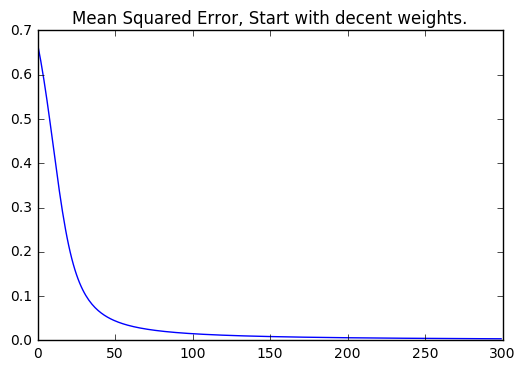

In [2]:
# Copying Nielsen's first example:
# initial weight = 0.6, bias = 0.9, learning rate = 0.15, mse cost function
# It learns fairly quickly, error is 0 by about 250 epochs.
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(7)

X = np.ones((1))
y = np.zeros((1))

model=Sequential()
model.add(Dense(1, input_dim=1, activation='sigmoid', 
                weights=[np.float32([[0.6]]),np.float32([0.9])]))

sgd = SGD(lr=0.15)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mean_squared_error'])
fit_result = model.fit(X,y, batch_size=2, nb_epoch=300, verbose=0)

print('Learned weights', model.get_weights()[0])
print('Learned bias', model.get_weights()[1])

plt.title('Mean Squared Error, Start with decent weights.')
plt.plot(fit_result.history['mean_squared_error'])
plt.show()

Learned weights [[-1.23814285]]
Learned bias [-1.23814285]


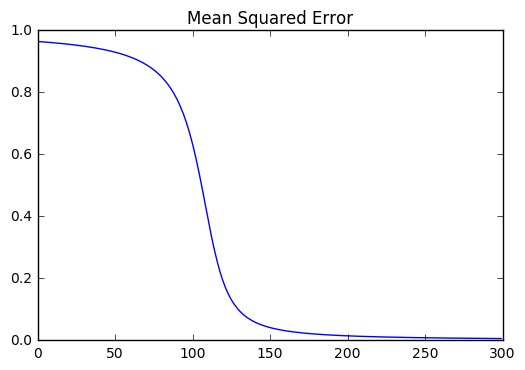

In [3]:
# Same example, this time with worse starting weight and bias, both = 2.0.
# This should demonstrate that the model is sensitive to the initial weights and bias.
# The difference in shapes mirror his demos almost perfectly.
# The point is that the neuron has a lot of difficulty learning when it's badly wrong,
# and much less when it's less wrong. This is a stark contrast to humans.

X = np.ones((1))
y = np.zeros((1))

model=Sequential()
model.add(Dense(1, input_dim=1, activation='sigmoid', 
                weights=[np.float32([[2.0]]),np.float32([2.0])]))

sgd = SGD(lr=0.15)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mean_squared_error'])
fit_result = model.fit(X,y, batch_size=2, nb_epoch=300, verbose=0)

print('Learned weights', model.get_weights()[0])
print('Learned bias', model.get_weights()[1])

plt.title('Mean Squared Error')
plt.plot(fit_result.history['mean_squared_error'])
plt.show()

## Cross-entropy cost function

$\begin{eqnarray} 
  C = -\frac{1}{n} \sum_x \left[y \ln a + (1-y ) \ln (1-a) \right],
\tag{57}\end{eqnarray}$

- What makes this a cost function?
    - It's non-negative.
    - When the actual output is close to the desired output for all training inputs, the sum will be small and vice versa.
    
- The weight and bias partial derivatives used in gradient descent:

$\begin{eqnarray} 
  \frac{\partial C}{\partial w_j} =  \frac{1}{n} \sum_x x_j(\sigma(z)-y).
\tag{61}\end{eqnarray}$

$\begin{eqnarray} 
  \frac{\partial C}{\partial b} = \frac{1}{n} \sum_x (\sigma(z)-y).
\tag{62}\end{eqnarray}$

- Notice this does not include $\sigma '$ which was the source of slow learning in the quadratic cost.
- When to use cross-entropy over quadratic?
    - Cross-entropy is almost always the better choice when using sigmoidal neurons.



## Exercise

- Verify the derivative of the sigmoid function. See: http://math.stackexchange.com/a/1225116

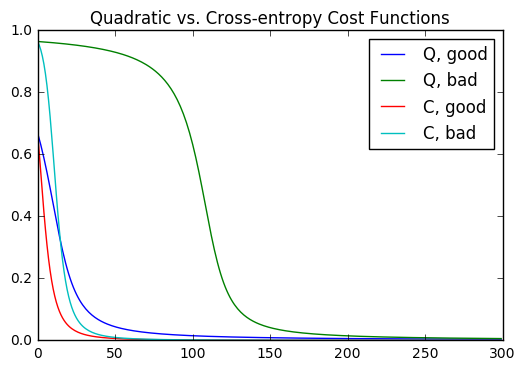

In [4]:
# Combining the examples:
# 1. Quadratic cost with good initial weight and bias.
# 2. Quadratic cost with poor initial weight and bias.
# 3. Cross entropy with good initial weight and bias.
# 4. Cross entropy with poor initial weight and bias.
# The thing to pay attention to here is that the cross-entropy cost function 
# still learns very quickly with bad weights, which is not the case for quadratic.
# This becomes painfully apparent if you decrease the learning rate for SGD.
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(7)

X = np.ones((1))
y = np.zeros((1))

# All using same stochastic gradient descent.
sgd = SGD(lr=0.15)

tests = [
    ('Q, good', 'mean_squared_error', [np.float32([[0.6]]),np.float32([0.9])]),
    ('Q, bad', 'mean_squared_error', [np.float32([[2.0]]),np.float32([2.0])]),
    ('C, good', 'binary_crossentropy', [np.float32([[0.6]]),np.float32([0.9])]),
    ('C, bad', 'binary_crossentropy', [np.float32([[2.0]]),np.float32([2.0])])
]

for test in tests:
    model=Sequential()
    model.add(Dense(1, input_dim=1, activation='sigmoid', weights=test[2]))
    model.compile(loss=test[1], optimizer=sgd, metrics=['mean_squared_error'])
    fit_result = model.fit(X,y, batch_size=2, nb_epoch=300, verbose=0)
    plt.plot(fit_result.history['mean_squared_error'], label=test[0])

plt.title('Quadratic vs. Cross-entropy Cost Functions')
plt.legend()
plt.show()

## Exercises

- It's easy to confuse the crossentropy form $-[y \ln a + (1 - y) \ln (1 - a)]$ with $-[a \ln y + (1 - a) \ln (1-y)]$ What happens to the second expression at $y = 0$ and $y = 1$? Does this afflict the first expression? Why or why not?

In the mixed up case, $y = 0$ and $y = 1$ both yield an error that approaches $\infty$. This is not the case with the correct form. See below:

In [5]:
import numpy as np

def correct(y,a):
    return -(y*np.log(a)+(1-y)*np.log(1-a))

def mixedup(y,a):
    return -(a*np.log(y)+(1-a)*np.log(1-y))

print(correct(0, 0.5), correct(1, 0.5))
print(mixedup(0, 0.5), mixedup(1, 0.5))

0.69314718056 0.69314718056
inf inf


/home/kzh/.anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log


## Exercises

- Show that if the output layers are linear neurons, no problem arises from the quadratic cost. 

See empirical evaluation below. It actually learns extremely quickly. This demonstrates that the quadratic cost can be used if the outputs are linear.

Learned weights [[ 1.94851291]]
Learned bias [ 1.94851291]


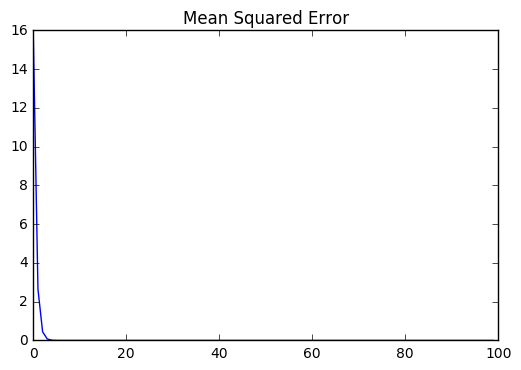

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt

X = np.ones((1))
y = np.zeros((1))

model=Sequential()
model.add(Dense(1, input_dim=1, activation='sigmoid', 
                weights=[np.float32([[2.0]]),np.float32([2.0])]))
model.add(Dense(1, input_dim=1, activation='linear', 
                weights=[np.float32([[2.0]]),np.float32([2.0])]))

sgd = SGD(lr=0.15)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mean_squared_error'])
fit_result = model.fit(X,y, batch_size=2, nb_epoch=100, verbose=0)

print('Learned weights', model.get_weights()[0])
print('Learned bias', model.get_weights()[1])

plt.title('Mean Squared Error')
plt.plot(fit_result.history['mean_squared_error'])
plt.show()

## Using Cross-entropy for MNIST

- Implementing mnist using cross-entropy cost function and comparing to the quadratic cost function. Using Keras to make things faster.

60000 training
10000 testing
Cross-entropy, sigmoid output compile and fit
Cross-entropy, sigmoid output holdout accuracy 0.9637
Quadratic, sigmoid output compile and fit
Quadratic, sigmoid output holdout accuracy 0.8927
Cross-entropy, linear output compile and fit
Cross-entropy, linear output holdout accuracy 0.0974
Quadratic, linear output compile and fit
Quadratic, linear output holdout accuracy 0.9244
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_23 (Dense)                 (None, 30)            23550       dense_input_15[0][0]             
____________________________________________________________________________________________________
dense_24 (Dense)                 (None, 10)            310         dense_23[0][0]                   
Total params: 23,860
Trainable params: 23,860
Non-trainable params: 0
________________

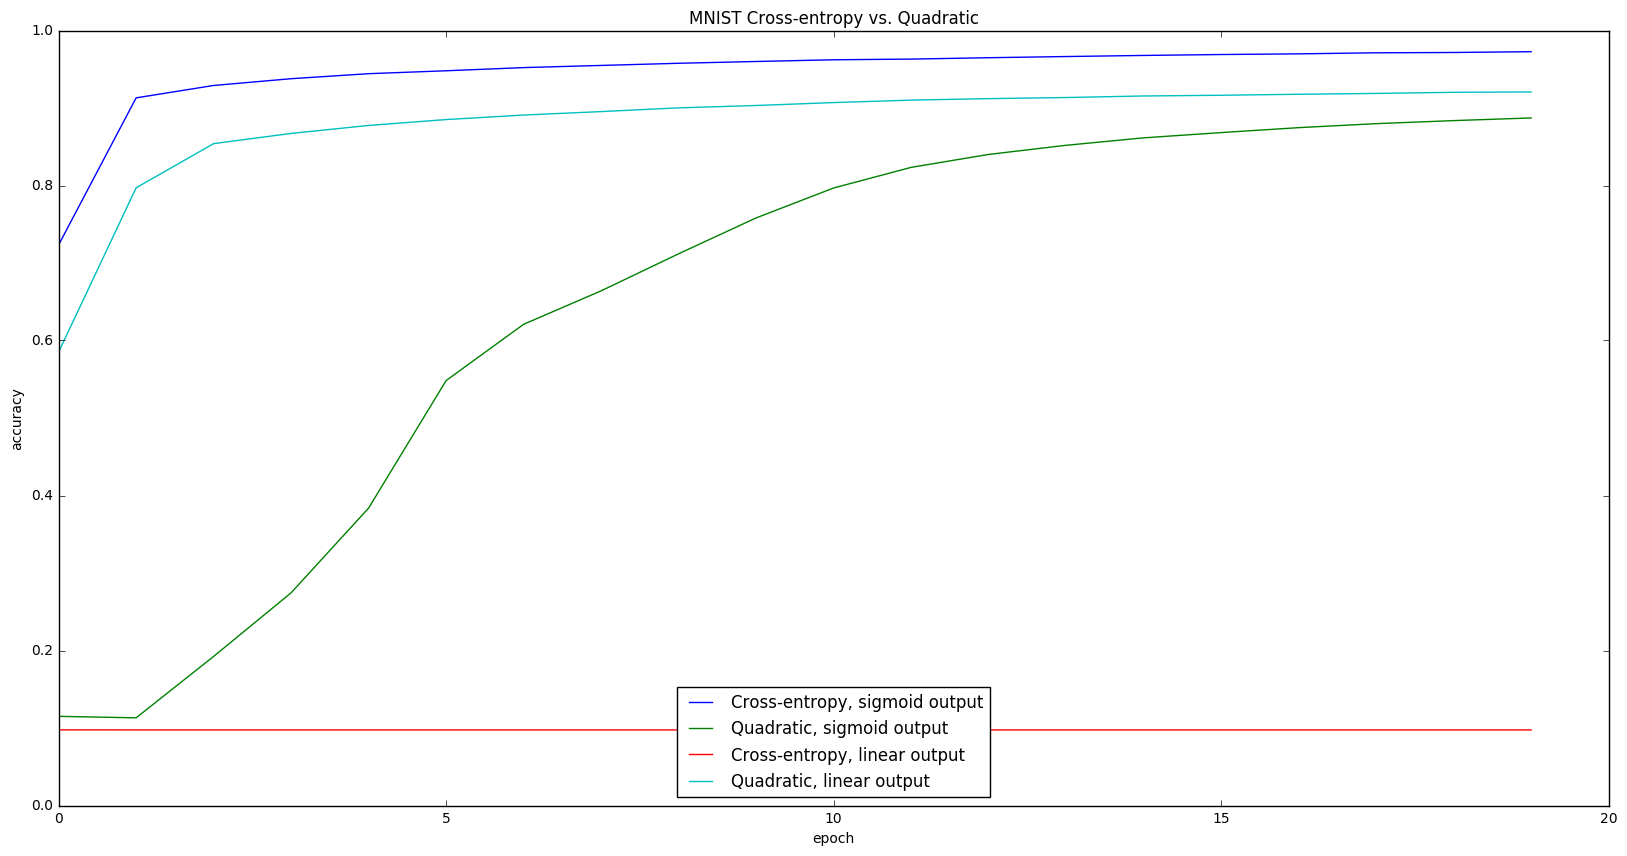

In [8]:
# Comparing a few combinations of cost function and output layer activations.
# Hypothesis: the cross-entropy cost function learns more quickly than
# the quadratic when using the sigmoid function on the output layer, but 
# they are very similar rates when using a linear output.
# Conclusion: Cross-entropy with linear output is really bad.
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from keras.utils import np_utils

batch_size = 128
nb_train = 60000
nb_test = 10000
nb_pixel = 784
nb_classes = 10
nb_epochs = 20

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshape and scale the images.
X_train = X_train.reshape(nb_train, nb_pixel).astype('float32') / 255
X_test = X_test.reshape(nb_test, nb_pixel).astype('float32') / 255

print(X_train.shape[0], 'training')
print(X_test.shape[0], 'testing')

# Convert class labels e.g. '3' to binary class matrices e.g. [0 0 0 1 0 ..].
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

test_configs = [
    # (Name, cost function, output layer activation.)
    ('Cross-entropy, sigmoid output', 'categorical_crossentropy', 'sigmoid'),
    ('Quadratic, sigmoid output', 'mean_squared_error', 'sigmoid'),
    ('Cross-entropy, linear output', 'categorical_crossentropy', 'linear'),
    ('Quadratic, linear output', 'mean_squared_error', 'linear')
]

plt.figure(figsize=(20,10))

for config in test_configs:
    
    np.random.seed(1337)
    # Defining the model.
    model = Sequential()
    # 30 neurons hidden with 784 inputs, (30 x 784) + 30 parameters for each weight and bias.
    model.add(Dense(30, input_shape=(nb_pixel,), activation='sigmoid', init='uniform'))
    # 10 neurons output, (30 x 10) + 30 parameters.
    model.add(Dense(10, activation=config[2], init='uniform'))
    
    print(config[0], 'compile and fit')
    model.compile(loss=config[1], optimizer=SGD(lr=0.5), metrics=['accuracy'])
    fit_result = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epochs,
                    verbose=0, validation_data=(X_test, y_test))
    
    score = model.evaluate(X_test, y_test, verbose=0)
    print(config[0], 'holdout accuracy', score[1])
    plt.plot(fit_result.history['acc'], label=config[0])

model.summary()

plt.title('MNIST Cross-entropy vs. Quadratic')
plt.legend(loc='lower center')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()    